In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.layers import Flatten
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

Using TensorFlow backend.


### Function to reframe the vectors to prepare for a multivariate supervised training of time series

source: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [2]:
train_df = pd.read_csv('data/cleaned_data.csv')

In [3]:
train_df.head()

,timestamp,passenger_count,trip_distance,total_amount,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,amount_rate,time
0,1498050000,26805,45733.59,285315.95,57.0,1014.0,295.37,25,290.0,3.0,0.000233,2017-06-21 15:00:00
1,1486310400,27487,50781.62,262346.81,51.0,1016.0,273.91,17,250.0,5.0,0.000188,2017-02-05 17:00:00
2,1464897600,41686,71816.81,400042.82,82.0,1020.0,296.72,6,90.0,5.0,0.000134,2016-06-02 22:00:00
3,1456308000,31526,44498.25,291332.16,86.0,1019.0,275.77,15,70.0,6.0,0.000208,2016-02-24 11:00:00
4,1458097200,4138,9353.05,42545.26,81.0,1010.0,282.52,17,15.0,1.0,0.001099,2016-03-16 04:00:00


### Sorting the cleaned dataframe by the time

In [4]:
train_df.sort_values('time', ascending=True, inplace = True)
train_df.reset_index(inplace = True)

In [5]:
timearr = train_df.time.values

In [6]:
train_df.drop(['timestamp', 'time'], axis = 1, inplace = True)

### Extracting the values from the dataframe to a two dimension vector

In [7]:
vals = train_df.values

### Scaling the X and y values with a MinMaxScaler to optimize the loss functions for training

In [8]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
x_vals = vals[:,1:]
y_vals = vals[:,:1]

In [10]:
x_vals_scaled = X_scaler.fit_transform(x_vals)
y_vals_scaled = y_scaler.fit_transform(y_vals)

In [11]:
vals_scaled = np.concatenate((y_vals_scaled, x_vals_scaled), axis = 1)

### Reframing the dataframe for multivariate supervised timeseries modelling

In [12]:
vals_scaled_reframed = series_to_supervised(vals_scaled)

In [13]:
vals_scaled_reframed.drop(['var1(t)','var2(t)','var3(t)','var4(t)','var5(t)','var6(t)','var7(t)','var8(t)','var9(t)','var10(t)'], axis = 1, inplace = True)

In [14]:
vals_final = vals_scaled_reframed.values

## Separating training and test sets

In [15]:
test_frac = 0.20
train_size = int(round(vals_final.shape[0]*(1-test_frac)))

In [16]:
train_set = vals_final[:train_size, :]
test_set = vals_final[train_size:, :]

In [17]:
X_train, y_train = train_set[:,1:], train_set[:,:1] 
X_test, y_test = test_set[:,1:], test_set[:,:1]

In [18]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### A simple LSTM model with Keras

In [19]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                19456     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 19,521
Trainable params: 19,521
Non-trainable params: 0
_________________________________________________________________


### Execute the next cell if you experience OS errors on mac if in case the keras model training doesn't work

In [21]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Training the keras model for 50 epochs 
(asymptote on the loss reaches around 30 epochs)

In [22]:
hist = model.fit(X_train, y_train,  epochs=50, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 12798 samples, validate on 3199 samples
Epoch 1/50
 - 11s - loss: 0.0967 - val_loss: 0.0846
Epoch 2/50
 - 4s - loss: 0.0846 - val_loss: 0.0842
Epoch 3/50
 - 5s - loss: 0.0843 - val_loss: 0.0841
Epoch 4/50
 - 5s - loss: 0.0841 - val_loss: 0.0840
Epoch 5/50
 - 4s - loss: 0.0839 - val_loss: 0.0839
Epoch 6/50
 - 4s - loss: 0.0838 - val_loss: 0.0838
Epoch 7/50
 - 4s - loss: 0.0837 - val_loss: 0.0838
Epoch 8/50
 - 5s - loss: 0.0837 - val_loss: 0.0838
Epoch 9/50
 - 4s - loss: 0.0836 - val_loss: 0.0837
Epoch 10/50
 - 5s - loss: 0.0836 - val_loss: 0.0837
Epoch 11/50
 - 4s - loss: 0.0836 - val_loss: 0.0837
Epoch 12/50
 - 5s - loss: 0.0836 - val_loss: 0.0837
Epoch 13/50
 - 4s - loss: 0.0836 - val_loss: 0.0837
Epoch 14/50
 - 5s - loss: 0.0835 - val_loss: 0.0837
Epoch 15/50
 - 4s - loss: 0.0835 - val_loss: 0.0837
Epoch 16/50
 - 5s - loss: 0.0835 - val_loss: 0.0837
Epoch 17/50
 - 4s - loss: 0.0835 - val_loss: 0.0837
Epoch 18/50
 - 5s - loss: 0.0835 - val_loss: 0.0837
Epoch 19/50
 - 5s - los

### Loss over training epochs

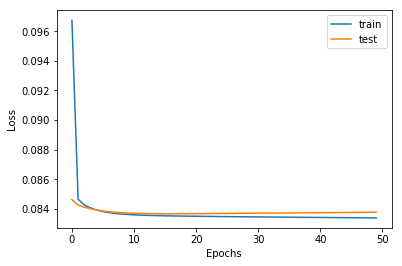

In [23]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Model performance

make a prediction

In [24]:
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

invert scaling for forecast

In [25]:
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = y_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


invert scaling for actual

In [26]:
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = y_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


calculate RMSE

In [27]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4629.946
